In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# 1. Data set preparation
Read movies_prep and ratings_sample csv files. The former contains the category of each film, and the latter contains the user ratings for the films.

Normalize each user's ratings with the average rating of the given user.

For the movie categories (genre_), replace nan values with 0, and then multiply the normalized rating of the given movie. Then generate how much each user likes each category on average, so that it is in a suitable form for the clustering algorithm.

## 1.1 Loading and reading the files

Let's load the csv files into the notebook

In [2]:
df_movies = pd.read_csv('/content/movies_prep.csv')
df_ratings = pd.read_csv('/content/ratings_sample.csv')

Let's visualice it to make sure we correctly uploaded them.

In [3]:
df_movies.head()

,movieId,title,genres,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Fantasy,genre_Romance,genre_Drama,...,genre_Thriller,genre_Horror,genre_Mystery,genre_Sci-Fi,genre_IMAX,genre_Documentary,genre_War,genre_Musical,genre_Western,genre_Film-Noir
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_movies.shape

(62423, 22)

In [5]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,123759,3243,3.0,1017030084
1,104903,594,2.0,1082736879
2,14310,2953,4.0,992503206
3,62120,3917,1.0,1460077438
4,9650,98809,1.0,1500832106


In [6]:
df_ratings.shape

(3000000, 4)

## 1.2 Normalization of user ratings


Now for the data preparation we will normalize each user's ratings with the average rating of the given user

In [7]:
# Calculating the average rating per user
df_ratings['avg_rating'] = df_ratings.groupby('userId')['rating'].transform('mean')

In [8]:
df_ratings.head()

,userId,movieId,rating,timestamp,avg_rating
0,123759,3243,3.0,1017030084,3.701149
1,104903,594,2.0,1082736879,3.521739
2,14310,2953,4.0,992503206,3.666667
3,62120,3917,1.0,1460077438,2.457447
4,9650,98809,1.0,1500832106,3.696429


After obtaining the average rating per user, let's Normalize the ratings by subtracting the user's average rating.

In [9]:
# Rating normalization
df_ratings['normalized_rating'] = df_ratings['rating'] - df_ratings['avg_rating']

In [10]:
df_ratings.head()

,userId,movieId,rating,timestamp,avg_rating,normalized_rating
0,123759,3243,3.0,1017030084,3.701149,-0.701149
1,104903,594,2.0,1082736879,3.521739,-1.521739
2,14310,2953,4.0,992503206,3.666667,0.333333
3,62120,3917,1.0,1460077438,2.457447,-1.457447
4,9650,98809,1.0,1500832106,3.696429,-2.696429


For the movie categories (genre_), let's replace nan values with 0, and then multiply the normalized rating of the given movie.

In [11]:
nan_counts = df_movies.isnull().sum()
print(nan_counts)

movieId              0
title                0
genres               0
genre_Adventure      0
genre_Animation      0
genre_Children       0
genre_Comedy         0
genre_Fantasy        0
genre_Romance        0
genre_Drama          0
genre_Action         0
genre_Crime          0
genre_Thriller       0
genre_Horror         0
genre_Mystery        0
genre_Sci-Fi         0
genre_IMAX           0
genre_Documentary    0
genre_War            0
genre_Musical        0
genre_Western        0
genre_Film-Noir      0
dtype: int64


## 1.3 Merging of datasets on 'MovieId'

Let's generate how much each user likes each category on average, so that it is in a suitable form for the clustering algorithm.

In [12]:
# Let's merge the normalized ratings with the movie data to calculate how much each user likes each genre
merged_df = pd.merge(df_ratings, df_movies, on='movieId', how='inner')

In [13]:
merged_df.head()

,userId,movieId,rating,timestamp,avg_rating,normalized_rating,title,genres,genre_Adventure,genre_Animation,...,genre_Thriller,genre_Horror,genre_Mystery,genre_Sci-Fi,genre_IMAX,genre_Documentary,genre_War,genre_Musical,genre_Western,genre_Film-Noir
0,123759,3243,3.0,1017030084,3.701149,-0.701149,Encino Man (1992),Comedy,0,0,...,0,0,0,0,0,0,0,0,0,0
1,104903,594,2.0,1082736879,3.521739,-1.521739,Snow White and the Seven Dwarfs (1937),Animation|Children|Drama|Fantasy|Musical,0,1,...,0,0,0,0,0,0,0,1,0,0
2,14310,2953,4.0,992503206,3.666667,0.333333,Home Alone 2: Lost in New York (1992),Children|Comedy,0,0,...,0,0,0,0,0,0,0,0,0,0
3,62120,3917,1.0,1460077438,2.457447,-1.457447,Hellraiser (1987),Horror,0,0,...,0,1,0,0,0,0,0,0,0,0
4,9650,98809,1.0,1500832106,3.696429,-2.696429,"Hobbit: An Unexpected Journey, The (2012)",Adventure|Fantasy|IMAX,1,0,...,0,0,0,0,1,0,0,0,0,0


In [14]:
merged_df.shape

(3000000, 27)

In [15]:
# List of genre columns (assuming they all start with 'genre_')
genre_columns = [col for col in df_movies.columns if col.startswith('genre_')]

In [16]:
# Display the genre columns
print("Genre columns:", genre_columns)
print("Number of genre columns:", len(genre_columns))

Genre columns: ['genre_Adventure', 'genre_Animation', 'genre_Children', 'genre_Comedy', 'genre_Fantasy', 'genre_Romance', 'genre_Drama', 'genre_Action', 'genre_Crime', 'genre_Thriller', 'genre_Horror', 'genre_Mystery', 'genre_Sci-Fi', 'genre_IMAX', 'genre_Documentary', 'genre_War', 'genre_Musical', 'genre_Western', 'genre_Film-Noir']
Number of genre columns: 19


In [17]:
# For each genre lets multiply the normalized rating by the genre value (0 or 1) by each genre column to get the preference for each genre
for genre in genre_columns:
    merged_df[f'{genre}_preference'] = merged_df['normalized_rating'] * merged_df[genre]

In [18]:
# Verify if the columns had been created
merged_df.head()

,userId,movieId,rating,timestamp,avg_rating,normalized_rating,title,genres,genre_Adventure,genre_Animation,...,genre_Thriller_preference,genre_Horror_preference,genre_Mystery_preference,genre_Sci-Fi_preference,genre_IMAX_preference,genre_Documentary_preference,genre_War_preference,genre_Musical_preference,genre_Western_preference,genre_Film-Noir_preference
0,123759,3243,3.0,1017030084,3.701149,-0.701149,Encino Man (1992),Comedy,0,0,...,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.0,-0.0
1,104903,594,2.0,1082736879,3.521739,-1.521739,Snow White and the Seven Dwarfs (1937),Animation|Children|Drama|Fantasy|Musical,0,1,...,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.0,-0.0,-1.521739,-0.0,-0.0
2,14310,2953,4.0,992503206,3.666667,0.333333,Home Alone 2: Lost in New York (1992),Children|Comedy,0,0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
3,62120,3917,1.0,1460077438,2.457447,-1.457447,Hellraiser (1987),Horror,0,0,...,-0.0,-1.457447,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.0,-0.0
4,9650,98809,1.0,1500832106,3.696429,-2.696429,"Hobbit: An Unexpected Journey, The (2012)",Adventure|Fantasy|IMAX,1,0,...,-0.0,-0.000000,-0.0,-0.0,-2.696429,-0.0,-0.0,-0.000000,-0.0,-0.0


## 1.4 Calculate the average genre preferences for each user

In [19]:
# Group by userId and calculate the average genre preferences for each user
genre_preferences = merged_df.groupby('userId')[[f'{genre}_preference' for genre in genre_columns]].mean()

In [20]:
# Display the calculated preferences
print(genre_preferences)

        genre_Adventure_preference  genre_Animation_preference  \
userId                                                           
1                     2.469136e-02                    0.000000   
2                     1.104000e-01                    0.027200   
3                     1.675849e-02                    0.006428   
4                    -1.758585e-01                    0.102497   
5                    -4.444444e-02                    0.035556   
...                            ...                         ...   
162537               -1.000000e-01                    0.000000   
162538               -8.875740e-02                    0.000000   
162539                1.480297e-16                    0.111111   
162540                2.107438e-01                    0.210744   
162541                1.500000e-01                    0.080000   

        genre_Children_preference  genre_Comedy_preference  \
userId                                                       
1                

# 2. K-Means clustering
Find how many clusters should be created from the users using the K-Means algorithm (with random_state = 42). Then do the clustering and conclude which cluster has the 3 best and 3 least liked movie categories. Which category most influences the clustering result?

## 2.1 Finding how many clusters should be created based on K-means

In [21]:
# Use the Elbow method to find the optimal number of clusters
X = genre_preferences
sse = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)


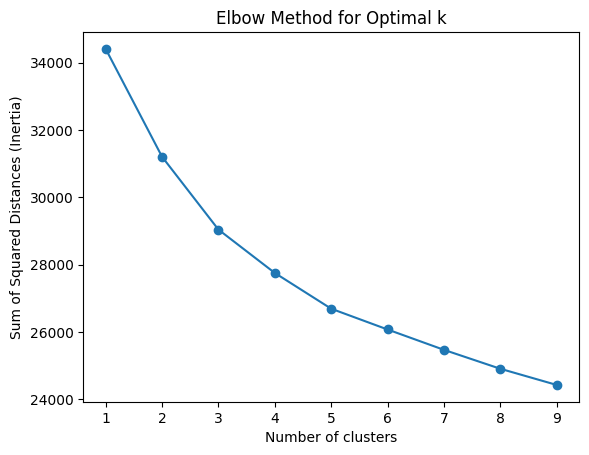

In [22]:
# Plot the Elbow curve
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()

Based on the graph we can consider 4 as the optimal number in clusters.

In [23]:
k_optimal = 4

# Perform K-Means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
genre_preferences['cluster'] = kmeans.fit_predict(X)

# Check cluster assignment
print(genre_preferences['cluster'].value_counts())


cluster
2    95457
1    24631
0    20808
3    19812
Name: count, dtype: int64


## 2.2 Clustering and Top 3 for best and least movie categories.

In [24]:
# Lets calculate the average genre preference per cluster
cluster_genre_preferences = genre_preferences.groupby('cluster').mean()

# Lets identify the top 3 best and least liked categories for each cluster
for cluster in range(k_optimal):
    print(f"\nCluster {cluster}:")

# Sort the genres by average preference within the cluster
    best_genres = cluster_genre_preferences.loc[cluster].sort_values(ascending=False).head(3)
    least_genres = cluster_genre_preferences.loc[cluster].sort_values(ascending=True).head(3)

    print(f"Top 3 best liked genres:\n{best_genres}\n\nTop 3 least liked genres:\n{least_genres}")



Cluster 0:
Top 3 best liked genres:
genre_Adventure_preference    0.145454
genre_Action_preference       0.118045
genre_Sci-Fi_preference       0.075823
Name: 0, dtype: float64

Top 3 least liked genres:
genre_Drama_preference     -0.149212
genre_Romance_preference   -0.051516
genre_Crime_preference     -0.014553
Name: 0, dtype: float64

Cluster 1:
Top 3 best liked genres:
genre_Drama_preference       0.171250
genre_Thriller_preference    0.118106
genre_Crime_preference       0.084927
Name: 1, dtype: float64

Top 3 least liked genres:
genre_Comedy_preference     -0.213707
genre_Children_preference   -0.065006
genre_Fantasy_preference    -0.051666
Name: 1, dtype: float64

Cluster 2:
Top 3 best liked genres:
genre_Drama_preference    0.023849
genre_Crime_preference    0.009930
genre_War_preference      0.006670
Name: 2, dtype: float64

Top 3 least liked genres:
genre_Action_preference     -0.020169
genre_Sci-Fi_preference     -0.011108
genre_Thriller_preference   -0.009391
Name: 2, dtyp

## 2.3 Finding most influencing category in clustering

In [25]:
# Calculate the variance of each genre across clusters
genre_variance = cluster_genre_preferences.var().sort_values(ascending=False)
print(genre_variance)

genre_Drama_preference          2.425584e-02
genre_Action_preference         2.146202e-02
genre_Comedy_preference         1.553172e-02
genre_Adventure_preference      1.313192e-02
genre_Thriller_preference       9.471084e-03
genre_Sci-Fi_preference         7.459110e-03
genre_Romance_preference        3.562783e-03
genre_Crime_preference          1.864474e-03
genre_Children_preference       1.477875e-03
genre_Fantasy_preference        1.349851e-03
genre_Animation_preference      7.439148e-04
genre_Mystery_preference        4.392136e-04
genre_War_preference            2.965110e-04
genre_IMAX_preference           1.763699e-04
genre_Musical_preference        1.639890e-04
genre_Horror_preference         1.075881e-04
genre_Film-Noir_preference      4.486549e-06
genre_Documentary_preference    1.414858e-06
genre_Western_preference        2.113951e-07
dtype: float64


In [26]:
# Identify the genre with the highest variance
most_influential_genre = genre_variance.idxmax()
print(f"The most influential genre in clustering is: {most_influential_genre}")

The most influential genre in clustering is: genre_Drama_preference


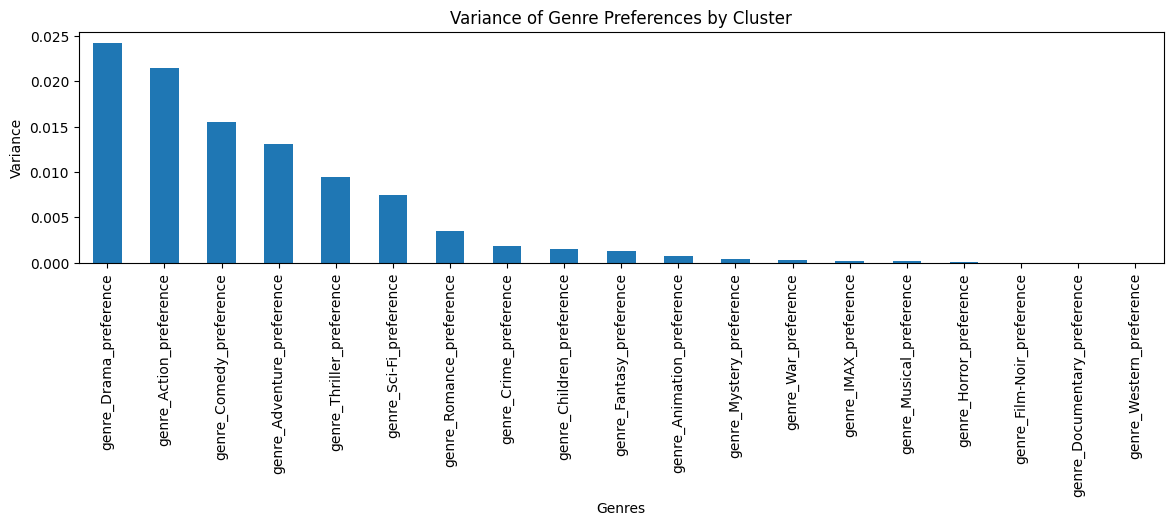

In [27]:
# Plot the sorted variances
plt.figure(figsize=(14, 3))
genre_variance.plot(kind='bar')
plt.xlabel('Genres')
plt.ylabel('Variance')
plt.title('Variance of Genre Preferences by Cluster')
plt.xticks(rotation=90)
plt.show()

# 3. Hierarchical clustering
Determine which film category is similar to which according to user ratings and how many groups the categories are classified into (linkage = 'complete').

Based on this, what additional film category would you recommend for those who like the Documentary category, which they would probably like?

Finally, based on the clustering of the previous and the current task, recommend to any user of your choice a movie from a category that they have not seen yet and would probably like.

## 3.1 Determine similarity in categories

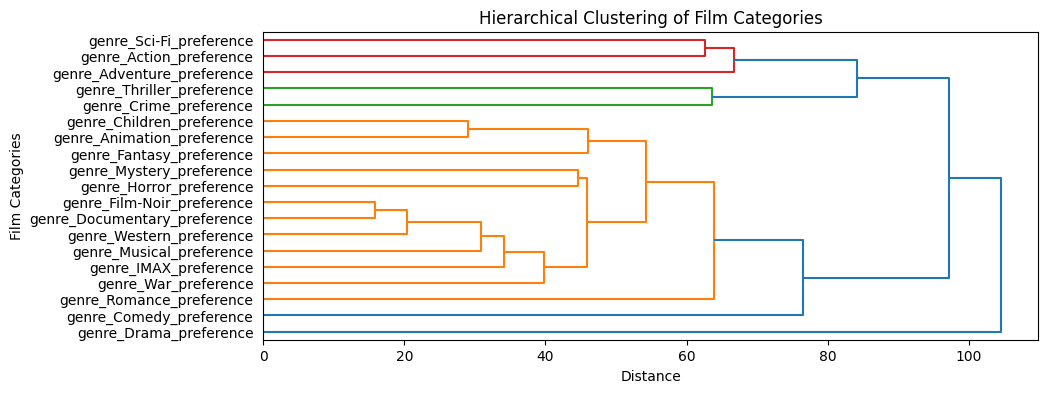

In [28]:
# Extract the genre columns from the user_genre_preferences DataFrame
genre_preferences_data = genre_preferences.drop('cluster', axis=1)

# Perform hierarchical clustering (linkage='complete')
linked = shc.linkage(genre_preferences_data.T, method='complete')

# Plot the dendrogram to visualize the clustering of genres
plt.figure(figsize=(10,4))
shc.dendrogram(linked, labels=genre_preferences_data.columns, orientation='right')
plt.title('Hierarchical Clustering of Film Categories')
plt.xlabel('Distance')
plt.ylabel('Film Categories')
plt.yticks(fontsize=10)
plt.show()

## 3.2 Recommendation for users base on category choises

Based on the dendogram we can recomend a similar genre to the users:
- If they like Sci-fi, they would like Action and Adventure as well.
- If they like Thriller, they would like Crime.
- If they like Children genre, they would like Animation and fantasy as well. They would also like Romance.
- If they like Mistery, they would like horror genre. They would also like Romance.
- If they like Film-noir, they would like Documentary and Western as well. Also they would enjoy Musical, IMAX, and War. They would also like Romance.
- Any user would like Drama.

## 3.3 Recommendation to users

We will recommend movies to 5 random users.

In [29]:
# Random 5 rows from the 'userId' column
random_userids = merged_df['userId'].sample(n=5, random_state=42)

print(random_userids)

2945667     97481
2352586     21211
1531260     25008
941910     159713
2582125     64584
Name: userId, dtype: int64


In [30]:
#Let's start with the user1
userid1 = 97481

# Show his genre preferences
userid1_preferences = genre_preferences.loc[userid1]
print(userid1_preferences)

genre_Adventure_preference     -0.007951
genre_Animation_preference     -0.005362
genre_Children_preference       0.000185
genre_Comedy_preference         0.004993
genre_Fantasy_preference       -0.021820
genre_Romance_preference        0.018306
genre_Drama_preference          0.061021
genre_Action_preference        -0.020340
genre_Crime_preference         -0.035503
genre_Thriller_preference      -0.036797
genre_Horror_preference         0.000000
genre_Mystery_preference        0.017936
genre_Sci-Fi_preference         0.011095
genre_IMAX_preference           0.024778
genre_Documentary_preference    0.000000
genre_War_preference            0.002774
genre_Musical_preference        0.000000
genre_Western_preference        0.002774
genre_Film-Noir_preference      0.000000
cluster                         2.000000
Name: 97481, dtype: float64


In [31]:
# Identify categories the user hasn't seen or rated
unseenrenge_userid1 = userid1_preferences[userid1_preferences == 0].index.tolist()
print(f'Unseen categories by userid1: {unseenrenge_userid1}')

Unseen categories by userid1: ['genre_Horror_preference', 'genre_Documentary_preference', 'genre_Musical_preference', 'genre_Film-Noir_preference']


In [32]:
# Recommend a movie from an unseen genre
unseenmoviesuserid1 = merged_df[(merged_df['userId'] != userid1) & (merged_df[unseenrenge_userid1].sum(axis=1) > 0)]

In [33]:
# Pick one unseen movie to recommend
recommendation_userid1 = unseenmoviesuserid1[['title', 'genres']].sample().reset_index(drop=True)
print(f'\nMovie recomended to userid1: {recommendation_userid1.to_string(index=False, header=False)}')


Movie recomended to userid1: Silence of the Lambs, The (1991) Crime|Horror|Thriller


Let's continue selecting random movies for the random users.

In [34]:
# Userid2
userid2 = 21211
userid2_preferences = genre_preferences.loc[userid2]

# Identify categories the user hasn't seen or rated
unseenrenge_userid2 = userid2_preferences[userid2_preferences == 0].index.tolist()
print(f'Unseen categories by userid2: {unseenrenge_userid2}')

# Recommend a movie from an unseen genre
unseenmoviesuserid2 = merged_df[(merged_df['userId'] != userid2) & (merged_df[unseenrenge_userid2].sum(axis=1) > 0)]

# Pick one unseen movie to recommend
recommendation_userid2 = unseenmoviesuserid1[['title', 'genres']].sample()
print(f'\nMovie recomended to userid2: {recommendation_userid2.to_string(index=False, header=False)}')


Unseen categories by userid2: ['genre_IMAX_preference', 'genre_War_preference', 'genre_Film-Noir_preference']

Movie recomended to userid2: Muppet Treasure Island (1996) Adventure|Children|Comedy|Musical


In [35]:
# Userid3
userid3 = 25008
userid3_preferences = genre_preferences.loc[userid3]

# Identify categories the user hasn't seen or rated
unseenrenge_userid3 = userid3_preferences[userid3_preferences == 0].index.tolist()
print(f'Unseen categories by userid3: {unseenrenge_userid3}')

# Recommend a movie from an unseen genre
unseenmoviesuserid3 = merged_df[(merged_df['userId'] != userid3) & (merged_df[unseenrenge_userid3].sum(axis=1) > 0)]

# Pick one unseen movie to recommend
recommendation_userid3 = unseenmoviesuserid1[['title', 'genres']].sample()
print(f'\nMovie recomended to userid3: {recommendation_userid3.to_string(index=False, header=False)}')

Unseen categories by userid3: ['genre_IMAX_preference', 'genre_Documentary_preference', 'genre_Musical_preference', 'genre_Western_preference', 'genre_Film-Noir_preference']

Movie recomended to userid3: Rocky Horror Picture Show, The (1975) Comedy|Horror|Musical|Sci-Fi


In [36]:
# Userid4
userid4 = 159713
userid4_preferences = genre_preferences.loc[userid4]

# Identify categories the user hasn't seen or rated
unseenrenge_userid4 = userid4_preferences[userid4_preferences == 0].index.tolist()
print(f'Unseen categories by userid4: {unseenrenge_userid4}')

# Recommend a movie from an unseen genre
unseenmoviesuserid4 = merged_df[(merged_df['userId'] != userid4) & (merged_df[unseenrenge_userid4].sum(axis=1) > 0)]

# Pick one unseen movie to recommend
recommendation_userid4 = unseenmoviesuserid1[['title', 'genres']].sample()
print(f'\nMovie recomended to userid4: {recommendation_userid4.to_string(index=False, header=False)}')

Unseen categories by userid4: ['genre_Documentary_preference', 'genre_Western_preference', 'genre_Film-Noir_preference']

Movie recomended to userid4: What We Do in the Shadows (2014) Comedy|Horror


In [37]:
# Userid5
userid5 = 64584
userid5_preferences = genre_preferences.loc[userid5]

# Identify categories the user hasn't seen or rated
unseenrenge_userid5 = userid5_preferences[userid5_preferences == 0].index.tolist()
print(f'Unseen categories by userid5: {unseenrenge_userid5}')

# Recommend a movie from an unseen genre
unseenmoviesuserid5 = merged_df[(merged_df['userId'] != userid5) & (merged_df[unseenrenge_userid5].sum(axis=1) > 0)]

# Pick one unseen movie to recommend
recommendation_userid5 = unseenmoviesuserid1[['title', 'genres']].sample()
print(f'\nMovie recomended to userid5: {recommendation_userid5.to_string(index=False, header=False)}')

Unseen categories by userid5: ['genre_Horror_preference', 'genre_Mystery_preference', 'genre_IMAX_preference', 'genre_Documentary_preference', 'genre_Musical_preference', 'genre_Western_preference', 'genre_Film-Noir_preference']

Movie recomended to userid5: American Psycho (2000) Crime|Horror|Mystery|Thriller
